# Accident Data - Machine Learning Modelling

In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import pickle
plt.style.use("classic")

In [2]:
# import data from pkl file
# load pickled data
with open("./data/working_sets/new_acc_ml_dataset.pkl", "rb") as f:
    acc = pickle.load(f)


In [3]:
acc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2178381 entries, 0 to 2178380
Data columns (total 18 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   police_force            category
 1   day                     category
 2   road_type               category
 3   proxy_severity          category
 4   adj_long                float64 
 5   adj_lat                 float64 
 6   num_veh_group           category
 7   num_cas_group           category
 8   ons_code                category
 9   single_carriageway      category
 10  speed_limit_over_30mph  category
 11  good_light              category
 12  fine_weather            category
 13  road_surface_okay       category
 14  time_of_day             category
 15  year                    category
 16  month                   category
 17  urban_area              category
dtypes: category(16), float64(2)
memory usage: 66.5 MB


In [4]:
# get balanced random sample

size = 10000        # sample size
replace = True  # with replacement
fn = lambda obj: obj.loc[np.random.choice(obj.index, size, replace),:]
acc = acc.groupby('proxy_severity', as_index=False).apply(fn)
acc.reset_index(drop=True, inplace=True) # reset index

In [5]:
acc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   police_force            30000 non-null  category
 1   day                     30000 non-null  category
 2   road_type               30000 non-null  category
 3   proxy_severity          30000 non-null  category
 4   adj_long                30000 non-null  float64 
 5   adj_lat                 30000 non-null  float64 
 6   num_veh_group           30000 non-null  category
 7   num_cas_group           30000 non-null  category
 8   ons_code                30000 non-null  category
 9   single_carriageway      30000 non-null  category
 10  speed_limit_over_30mph  30000 non-null  category
 11  good_light              30000 non-null  category
 12  fine_weather            30000 non-null  category
 13  road_surface_okay       30000 non-null  category
 14  time_of_day           

In [6]:
# reduce size to 2019 only

# acc = acc[acc["year"].astype(int) > 2015]
# acc.reset_index(drop=True, inplace=True)

In [7]:
# acc.proxy_severity.value_counts()

In [8]:
acc.index

RangeIndex(start=0, stop=30000, step=1)

In [9]:
acc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   police_force            30000 non-null  category
 1   day                     30000 non-null  category
 2   road_type               30000 non-null  category
 3   proxy_severity          30000 non-null  category
 4   adj_long                30000 non-null  float64 
 5   adj_lat                 30000 non-null  float64 
 6   num_veh_group           30000 non-null  category
 7   num_cas_group           30000 non-null  category
 8   ons_code                30000 non-null  category
 9   single_carriageway      30000 non-null  category
 10  speed_limit_over_30mph  30000 non-null  category
 11  good_light              30000 non-null  category
 12  fine_weather            30000 non-null  category
 13  road_surface_okay       30000 non-null  category
 14  time_of_day           

In [10]:
# get rid of year and month etc.
acc = acc.drop(["year","month"], axis=1)

In [11]:
acc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   police_force            30000 non-null  category
 1   day                     30000 non-null  category
 2   road_type               30000 non-null  category
 3   proxy_severity          30000 non-null  category
 4   adj_long                30000 non-null  float64 
 5   adj_lat                 30000 non-null  float64 
 6   num_veh_group           30000 non-null  category
 7   num_cas_group           30000 non-null  category
 8   ons_code                30000 non-null  category
 9   single_carriageway      30000 non-null  category
 10  speed_limit_over_30mph  30000 non-null  category
 11  good_light              30000 non-null  category
 12  fine_weather            30000 non-null  category
 13  road_surface_okay       30000 non-null  category
 14  time_of_day           

### Encode Categorical Attributes

- I will use SKLearn's One Hot Encoder for this
- One Hot Encoder might struggle with some of categories with many values, but its use of a sparse matrix might help with this. (we will see)

In [12]:
# instantiate one hot encoder
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()

cat_cols = ["num_veh_group", "num_cas_group", "ons_code", "time_of_day"]

In [13]:
# transform columns
from sklearn.compose import ColumnTransformer

cat_transf = ColumnTransformer([
    ("cat", OneHotEncoder(), cat_cols),],
    remainder = "passthrough")

### Create Train and Test Sets

In [14]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 1)

for train_index, test_index in split.split(acc, acc["proxy_severity"]):
    train = acc.loc[train_index]
    test = acc.loc[test_index]

In [15]:
# predictors (X)
X_train_set = train.drop("proxy_severity", axis=1)
X_test_set = test.drop("proxy_severity", axis=1)

X_train = cat_transf.fit_transform(X_train_set)
X_test = cat_transf.fit_transform(X_test_set)

# predicted
y_train = train["proxy_severity"].copy()
y_test = test["proxy_severity"].copy()

# Train Model

- decision tree selected as first model to train

In [16]:
# decision tree model
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn import metrics

dt_classifier = DecisionTreeClassifier(random_state = 2)
dt_classifier.fit(X_train, y_train)

# get score for model
dt_predictions = dt_classifier.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, dt_predictions))

Accuracy: 0.44216666666666665


In [17]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
confusion_matrix(y_test, dt_predictions)

array([[869, 645, 486],
       [659, 904, 437],
       [590, 530, 880]], dtype=int64)

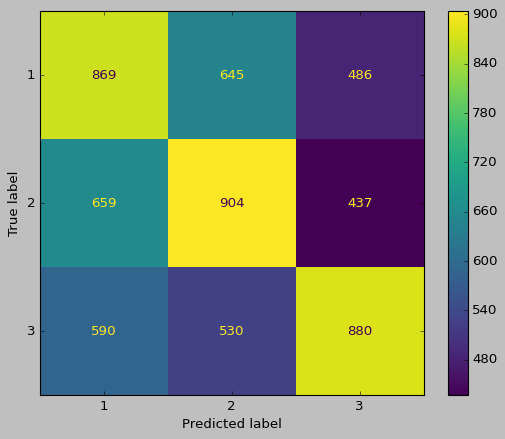

In [18]:
plot_confusion_matrix(dt_classifier, X_test, y_test)

## Random Forest Classifier

In [19]:
# random forest
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state = 1)
rf_classifier.fit(X_train, y_train)

# get score for model
rf_predictions = rf_classifier.predict(X_test)
rf_score = rf_classifier.score(X_test, y_test) * 100

print(rf_score)

48.03333333333333


In [20]:
print("Accuracy:",metrics.accuracy_score(y_test, rf_predictions))
confusion_matrix(y_test, rf_predictions)

Accuracy: 0.48033333333333333


array([[ 833,  611,  556],
       [ 581,  908,  511],
       [ 391,  468, 1141]], dtype=int64)

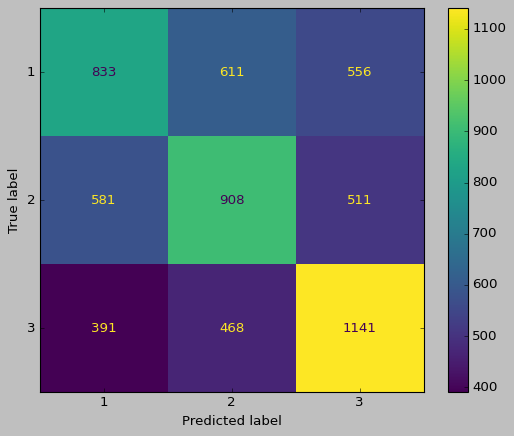

In [21]:
plot_confusion_matrix(rf_classifier, X_test, y_test, values_format = '.0f')

In [22]:
acc.to_csv("./data/FUCK.csv", index=False)

In [23]:
acc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   police_force            30000 non-null  category
 1   day                     30000 non-null  category
 2   road_type               30000 non-null  category
 3   proxy_severity          30000 non-null  category
 4   adj_long                30000 non-null  float64 
 5   adj_lat                 30000 non-null  float64 
 6   num_veh_group           30000 non-null  category
 7   num_cas_group           30000 non-null  category
 8   ons_code                30000 non-null  category
 9   single_carriageway      30000 non-null  category
 10  speed_limit_over_30mph  30000 non-null  category
 11  good_light              30000 non-null  category
 12  fine_weather            30000 non-null  category
 13  road_surface_okay       30000 non-null  category
 14  time_of_day           

## Gaussian Naive Bayes

In [24]:
# Gaussian Naive Bayes
from sklearn.naive_bayes import GaussianNB

gnb_classifier = GaussianNB()
gnb_classifier.fit(X_train, y_train)

# get score for model
gnb_predictions = gnb_classifier.predict(X_test)
gnb_score = gnb_classifier.score(X_test, y_test) * 100

print(gnb_score)

42.16666666666667


In [25]:
# confusion matrix
print("Accuracy:",metrics.accuracy_score(y_test, gnb_predictions))
confusion_matrix(y_test, gnb_predictions)

Accuracy: 0.4216666666666667


array([[1521,   58,  421],
       [1448,   92,  460],
       [1035,   48,  917]], dtype=int64)

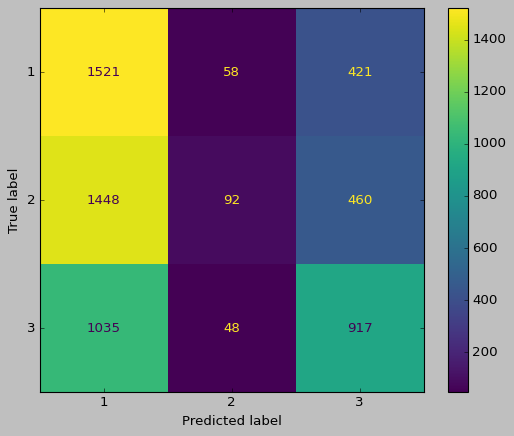

In [26]:
plot_confusion_matrix(gnb_classifier, X_test, y_test)

## K Nearest Neighbours Classifier

In [27]:
# K Nearest Neighbour classifier
from sklearn.neighbors import KNeighborsClassifier


knn_classifier = KNeighborsClassifier(n_neighbors = 1)
knn_classifier.fit(X_train, y_train)

# get score for model
knn_predictions = knn_classifier.predict(X_test)
knn_score = knn_classifier.score(X_test, y_test) * 100

print(knn_score)

43.88333333333333


In [28]:
# confusion matrix
print("Accuracy:",metrics.accuracy_score(y_test, knn_predictions))
confusion_matrix(y_test, knn_predictions)

Accuracy: 0.43883333333333335


array([[789, 655, 556],
       [629, 846, 525],
       [505, 497, 998]], dtype=int64)

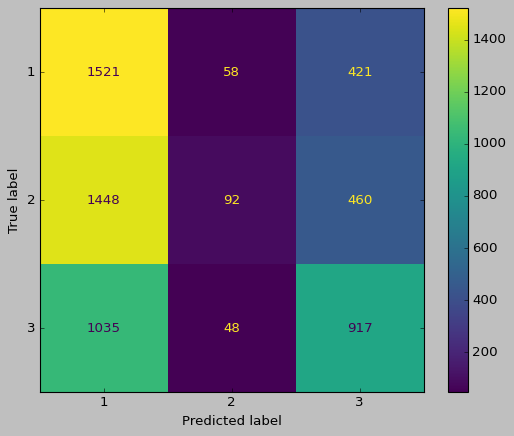

In [29]:
plot_confusion_matrix(gnb_classifier, X_test, y_test)

## Linear Discriminant Analysis

In [30]:
# Linear Descriminant Analysis
from sklearn.discriminant_analysis  import LinearDiscriminantAnalysis


lda_classifier = LinearDiscriminantAnalysis()
lda_classifier.fit(X_train, y_train)

# get score for model
lda_predictions = lda_classifier.predict(X_test)
lda_score = lda_classifier.score(X_test, y_test) * 100

print(lda_score)

48.06666666666667


In [31]:
# confusion matrix
print("Accuracy:",metrics.accuracy_score(y_test, lda_predictions))
confusion_matrix(y_test, lda_predictions)

Accuracy: 0.4806666666666667


array([[ 805,  543,  652],
       [ 601,  727,  672],
       [ 251,  397, 1352]], dtype=int64)

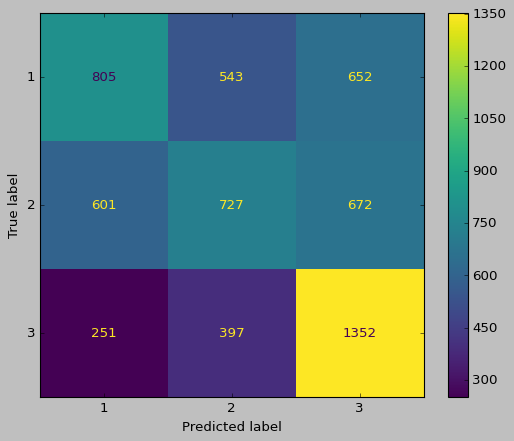

In [32]:
plot_confusion_matrix(lda_classifier, X_test, y_test, values_format='.0f')

## Neural Network MLP Classifier

In [33]:
# Linear Descriminant Analysis
from sklearn.neural_network  import MLPClassifier


mlp_classifier = MLPClassifier(random_state=1, max_iter=50)
mlp_classifier.fit(X_train, y_train)

# get score for model
mlp_predictions = mlp_classifier.predict(X_test)
mlp_score = mlp_classifier.score(X_test, y_test) * 100

print(mlp_score)

47.349999999999994


C:\Users\alanm\OneDrive - National College of Ireland\Final Year\Software Project\Project\projenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


In [34]:
# confusion matrix
print("Accuracy:",metrics.accuracy_score(y_test, mlp_predictions))
confusion_matrix(y_test, mlp_predictions)

Accuracy: 0.4735


array([[ 918,  107,  975],
       [ 781,  210, 1009],
       [ 217,   70, 1713]], dtype=int64)

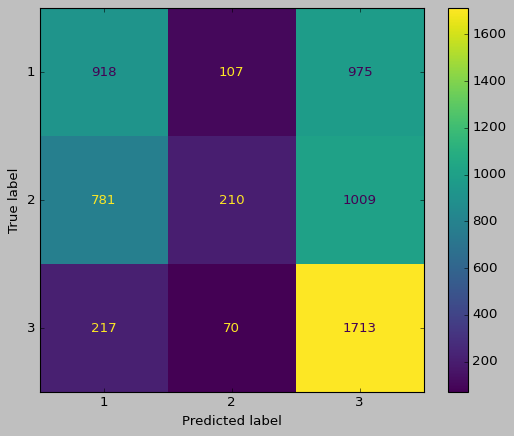

In [35]:
plot_confusion_matrix(mlp_classifier, X_test, y_test)

## Support Vector Machine (SVM)

In [36]:
# # SVM classifier
# from sklearn.pipeline import make_pipeline
# from sklearn.svm import SVC
# svm_classifier = SVC(random_state=1)

# svm_classifier.fit(X_train, y_train)

# # get score for model
# svm_predictions = svm_classifier.predict(X_test)
# svm_score = svm_classifier.score(X_test, y_test) * 100

# print(svm_score)